# FL Model test

In [1]:
# Standard imports
import random
import pandas as pd
import numpy as np

# Own Model import
from fl_model_funcs import *

#for nondominated sorting
import pareto

In [2]:
# For direct input model
nr_of_SPs = 1
nr_of_DPs = 5
nr_of_FLs = 6
nr_nodes = nr_of_SPs + nr_of_DPs + nr_of_FLs
areasize = 10

# Disruptions for each node

# DSR = Disruption Demand Points
# .5, 1.5: 50% of the time more or less, for traveling that distance
DSRDP = {"DSRDP{}".format(i): random.uniform (.5, 1.5) for i in range(nr_of_DPs)}
DSRFL = {"DSRFL{}".format(i): random.uniform (.5, 1.5) for i in range(nr_of_FLs)}

# Coordinates
SPX = {"SPX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_SPs)}
SPY = {"SPY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_SPs)}
DPX = {"DPX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_DPs)}
DPY = {"DPY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_DPs)}
FLX = {"FLX{}".format(i): random.uniform(0,areasize) for i in range(nr_of_FLs)}
FLY = {"FLY{}".format(i): random.uniform(0,areasize) for i in range(nr_of_FLs)}

FLO={"FLO0":1,"FLO1":1 ,"FLO2":0,"FLO3":1,"FLO4":0,"FLO5":0}

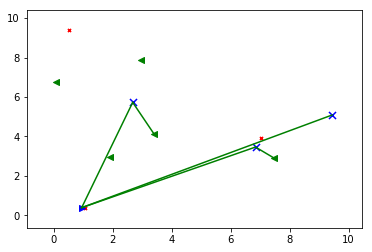

(791.4352668530153, 3, 30.0, 0.4241027169816553, 3)

In [3]:
# costs, nr_uncovered_DPs, total_uncovered_demand, total_distr_time, nr_op_fls = 
FL_model(
    100,
    1,
    True,
    FL_range=2,
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **FLO,
    **DSRDP,
    **DSRFL)

# FL Model Nepal

## Nepal Data

In [4]:
Nepal = pd.read_excel("Data/Nepal Cities Population.xlsx", usecols=[1,2,3,4])

# Take only larger cities, because of many null values under 50000 inhabitants. 
# TODO find better dataset with population and coordinates
Nepal = Nepal [Nepal.Population >= 50000]
Nepal.head(1)

,City,Population,Latitude (DD),Longitude (DD)
0,Kathmandu,743300,27.71,85.31


In [5]:
airports = pd.read_excel("Data/Nepal Airports.xlsx", usecols=[0,5,6])
int_airports = airports[airports['Airport'] == "Tribhuvan intl"]
int_airports.head()

,Airport,Latitude (DD),Longitude (DD)
7,Tribhuvan intl,27.7,85.36


## Nepal Instantiation 

In [8]:
# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(Nepal['Latitude (DD)'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(Nepal['Longitude (DD)'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(int_airports['Latitude (DD)'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(int_airports['Longitude (DD)'])}

# Create random facility locations
# lon lat min:

long_min, lat_min, long_max, lat_max = 80, 25.767, 88.183, 30.45

nr_of_FLs = 6
FLX = {"FLX{}".format(i): random.uniform(long_min,long_max) for i in range(nr_of_FLs)}
FLY = {"FLY{}".format(i): random.uniform(lat_min,lat_max) for i in range(nr_of_FLs)}
# # Uncertainties + Ranges
# # For direct input model
# nr_of_SPs = 1
# nr_of_DPs = 5

# nr_nodes = nr_of_SPs + nr_of_DPs + nr_of_FLs
# areasize = 10

# # Disruptions for each node

# DSR = Disruption Demand Points
# .5, 1.5: 50% of the time more or less, for traveling that distance
DSRDP = {"DSRDP{}".format(i): random.uniform (.5, 1.5) for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): random.uniform (.5, 1.5) for i in range(nr_of_FLs)}

# Decision Variables
FLO={"FLO0":0,"FLO1":0 ,"FLO2":0,"FLO3":0,"FLO4":0,"FLO5":0}

## Nepal Model Evaluator

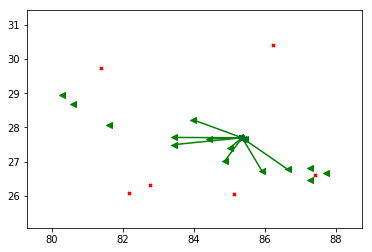

(1248.7264374146462, 6, 60.0, 0.2026094514501072, 0)

In [9]:
FL_model(
    100,
    1,
    True,
    FL_range=2,
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **FLO,
    **DSRDP,
    **DSRFL)

# Multi-Objective Optimisation Framework

Pseudocode:

    Current situation
    Create possible options (full factorial)
    Evaluate all possible options
    Check pareto front of outcomes

In [26]:
current_situation = FLO

In [27]:
def create_policies(FL_dict):
    """
    Takes the current network of Facility Locations and returns all possible policies for one added FL.
    
    Input: current option (Dict of FLs)
    Output: List of options (Dicts of FLs)
    """
    # All FL names
    FL_keys = sorted(FL_dict.keys())
    # All FL values indicating whether operational
    FL_values = [FL_dict[key] for key in FL_keys]
    
    i_operational_fls = i_FL_op = [i for i,x in enumerate(FL_values) if x == 1]
    
    # Create list of policies  
    pols = np.identity(len(FL_keys))
    # Set already operational facilities to operational
    pols[:,i_operational_fls] = 1
    
    #Delete policies where no new FLs are placed 
    new_n_operational_fls = sum(FL_values) + 1
    pols = pols[pols.sum(axis = 1) == new_n_operational_fls]

    
    # Return a list of dictionaries
    policy_list = []
    for pol in pols:
        policy_list.append({key:value for key,value in zip(FL_keys,pol)})
    
    return policy_list

In [28]:
policies = create_policies(current_situation)

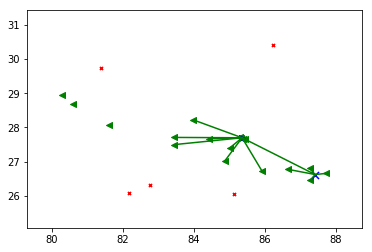

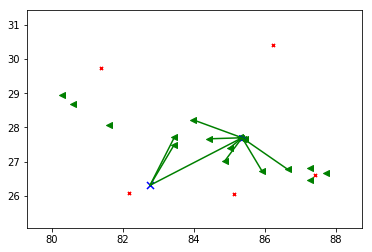

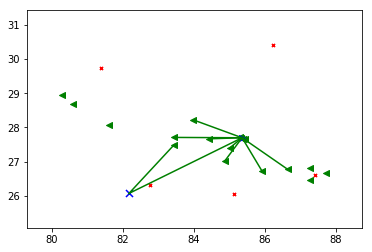

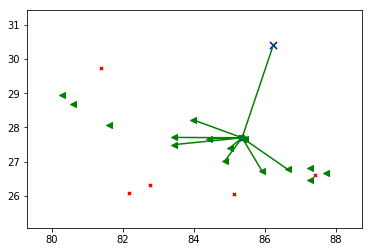

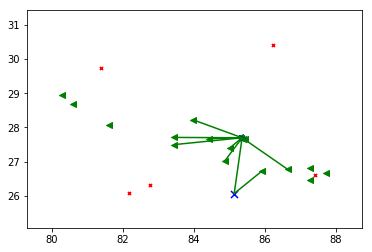

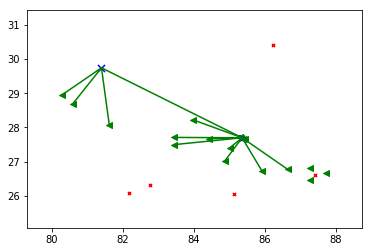

In [83]:
outcomes = []
for policy in policies:
    outcomes.append(FL_model(
    100,
    1,
    True,
    FL_range=2,
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **policy,
    **DSRDP,
    **DSRFL))

In [15]:
outcomes

[(2006.430213471732, 3, 30.0, 0.2367467995474345, 1.0),
 (1593.1493639363177, 6, 60.0, 0.2341483770468026, 1.0),
 (1777.3510999057207, 6, 60.0, 0.2620894494739965, 1.0),
 (1691.651757622334, 6, 60.0, 0.2502379681456194, 1.0),
 (1534.0967406053599, 6, 60.0, 0.22853720797318827, 1.0),
 (2983.2491826522646, 3, 30.0, 0.35796210924543653, 1.0)]

In [21]:
outcomes_df = pd.DataFrame(outcomes)

In [184]:
kwargs = {"maximize_all":True}
kwargs2 = {"maximize":[0,1]}

In [34]:
nondominated = pareto.eps_sort([list(outcomes_df.itertuples(True))],[1,2,3,4,5], [1e-9,1e-9,1e-9,1e-9,1e-9])

In [35]:
nondominated

[[0, 2006.430213471732, 3, 30.0, 0.2367467995474345, 1.0],
 [4, 1534.0967406053599, 6, 60.0, 0.22853720797318827, 1.0]]

# EMA Framework

In [82]:
from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
                                        RealParameter, ScalarOutcome,
                                        perform_experiments, Model)
from ema_workbench import ema_logging
# from ema_workbench.em_framework.

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [ ]:
Work this into ema framework

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(Nepal['Latitude (DD)'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(Nepal['Longitude (DD)'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(int_airports['Latitude (DD)'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(int_airports['Longitude (DD)'])}

# Create random facility locations
# lon lat min:

long_min, lat_min, long_max, lat_max = 80, 25.767, 88.183, 30.45

nr_of_FLs = 6
FLX = {"FLX{}".format(i): random.uniform(long_min,long_max) for i in range(nr_of_FLs)}
FLY = {"FLY{}".format(i): random.uniform(lat_min,lat_max) for i in range(nr_of_FLs)}
# # Uncertainties + Ranges
# # For direct input model
# nr_of_SPs = 1
# nr_of_DPs = 5

# nr_nodes = nr_of_SPs + nr_of_DPs + nr_of_FLs
# areasize = 10

# # Disruptions for each node

# DSR = Disruption Demand Points
# .5, 1.5: 50% of the time more or less, for traveling that distance
DSRDP = {"DSRDP{}".format(i): random.uniform (.5, 1.5) for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): random.uniform (.5, 1.5) for i in range(nr_of_FLs)}

# Decision Variables
FLO={"FLO0":0,"FLO1":0 ,"FLO2":0,"FLO3":0,"FLO4":0,"FLO5":0}

In [80]:
models = []
t = 0
model = Model("flmodelt{}".format(t), FL_model)

model.constants = [
    Constant ('graphical_representation', False),
]

model.uncertainties = [
    RealParameter('unit_opening_costs', 100, 200),
    RealParameter('unit_transport_cost', 0.5, 2), # cost of transporting one unit of relief goods
    RealParameter('FL_range', 2, 30), # km TODO: great circle distance
    RealParameter('lorry_speed',30,60) # km/h. Speed is Average speed. Constant, because roads are individually disrupted 
]


models.append(model)


In [81]:
for model in models:
    print(model.name)

flmodelt0


In [60]:
def create_ema_policies (FLs, )

SyntaxError: invalid syntax (<ipython-input-60-159aa41f105f>, line 1)

In [52]:
Policy("no_FLs",**{lever.name: 0 for lever in FL_EMAmodel.levers})

AttributeError: 'int' object has no attribute 'name'

# Robustness Framework

# Next iteration Framework